# Personalized Medicine: Redefining Cancer Treatment - Kaggle
---
## Problem Statement

We are basing this project on the ['Personalized Medicine: Redefining Cancer Treatment: Predict the effect of Genetic Variations to enable Personalized Medicine' competition from Kaggle](https://www.kaggle.com/c/msk-redefining-cancer-treatment). 

The goal of this project is to classify genetic mutations so that they are clinically actionable. This goal is important because manually labelling mutations can be labour intensive, time-consuming, and require domain expertise. Additionally, health care providers can use automatic classification to quickly determine whether a genetic mutation is neutral or is driving tumour growth.


**Datasets**:


*   *training_variants*
    *   ID: id
    *   Gene: location of genetic mutation
    *   Variation: mutation type
    *   Class: class of genetic mutation from 1-9


*   *training_text*
    *   ID: id
    *   TEXT: clinical evidence used to classify the genetic mutation


*   *test_variants*
    *   same as training


*   *test_text*
    *   same as training


## In this notebook

*   Exploratory data analysis (EDA)
*   Pre-processing of data
*   Model training
*   Model testing



## Data Loading

**Install dependencies**

In [ ]:
# data manipulation library
!pip install pandas  

# used for mathematical computation/statistics
!pip install numpy  

# data plotting and visualization
!pip install matplotlib  

# preprocessing of text
!pip install nltk  

# used to calculate the Cramer's Chi Squared correlation
!pip install researchpy

# for plotting model
!pip install scikit-plot

!pip install pickle-mixin

!pip install researchpy

     |████████████████████████████████| 231 kB 30.1 MB/s 
     |████████████████████████████████| 9.5 MB 42.1 MB/s 
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6008 sha256=f545632d088f65dbc5da569c9d8b4f13ac4a953b497a04d8921948de0b562d5d
  Stored in directory: /root/.cache/pip/wheels/d0/70/0b/673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157
Successfully built pickle-mixin


In [ ]:
# Import all the modules that we'll need for the project.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import researchpy

# Prints matplotlib graphs as static images within the notebook
%matplotlib inline

# Download the NLTK stop words corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from collections import Counter
from itertools import chain

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**Read in all raw data downloaded from https://www.kaggle.com/c/msk-redefining-cancer-treatment/data**

In [ ]:
# Unzipping all raw data files to data directory
!unzip "msk-redefining-cancer-treatment.zip" -d msk-redefining-cancer-treatment
!unzip 'msk-redefining-cancer-treatment/training_variants.zip' -d msk-redefining-cancer-treatment
!unzip 'msk-redefining-cancer-treatment/training_text.zip' -d msk-redefining-cancer-treatment
!unzip 'msk-redefining-cancer-treatment/test_variants.zip' -d msk-redefining-cancer-treatment
!unzip 'msk-redefining-cancer-treatment/test_text.zip' -d msk-redefining-cancer-treatment


Archive:  msk-redefining-cancer-treatment.zip
replace msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  msk-redefining-cancer-treatment/training_variants.zip
replace msk-redefining-cancer-treatment/training_variants? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  msk-redefining-cancer-treatment/training_text.zip
replace msk-redefining-cancer-treatment/training_text? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  msk-redefining-cancer-treatment/test_variants.zip
replace msk-redefining-cancer-treatment/test_variants? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  msk-redefining-cancer-treatment/test_text.zip
replace msk-redefining-cancer-treatment/test_text? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
cwd = os.getcwd()
training_variants_path = os.path.join(cwd, "msk-redefining-cancer-treatment/training_variants")
training_text_path = os.path.join(cwd, "msk-redefining-cancer-treatment/training_text")

# test_variants_path = os.path.join(cwd, "msk-redefining-cancer-treatment/test_variants")
# test_text_path = os.path.join(cwd, "msk-redefining-cancer-treatment/test_text")

test_variants_path_stage2 = os.path.join(cwd, "msk-redefining-cancer-treatment/stage2_test_variants.csv")
test_text_path_stage2 = os.path.join(cwd, "msk-redefining-cancer-treatment/stage2_test_text.csv")

# Reading in raw variants data into Pandas Dataframe
training_variants_raw_df = pd.read_csv(training_variants_path)
# test_variants_raw_df = pd.read_csv(test_variants_path)
test_variants_raw_df_stage2 = pd.read_csv(test_variants_path_stage2)

# Reading in raw text data into Pandas Dataframe
training_text_raw_df = pd.read_csv(training_text_path, sep="\|\|",engine="python",names=["ID","TEXT"], skiprows=1)
# test_text_raw_df = pd.read_csv(test_text_path, sep="\|\|",engine="python",names=["ID","TEXT"], skiprows=1)
test_text_raw_df_stage2 = pd.read_csv(test_text_path_stage2, sep="\|\|",engine="python",names=["ID","TEXT"], skiprows=1)


## Variants Exploratory Data Analysis

### "Variants" Data Analysis

In [ ]:
# Get data shape

print("Sample size:", training_variants_raw_df.shape[0])  # records
print("Number of Features:", training_variants_raw_df.shape[1])  # column headers
print("Features:", training_variants_raw_df.columns.values)  # column names

Sample size: 3321
Number of Features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


In [ ]:
# Get first 10 values

training_variants_raw_df.head(n=10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [ ]:
# Get last 10 values

training_variants_raw_df.tail(n=10)

,ID,Gene,Variation,Class
3311,3311,RUNX1,RUNX1-EVI1 Fusion,4
3312,3312,RUNX1,TEL-RUNX1 Fusion,4
3313,3313,RUNX1,H78Q,4
3314,3314,RUNX1,G42R,6
3315,3315,RUNX1,RUNX1-RUNX1T1 Fusion,4
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4
3320,3320,RUNX1,K83E,4


In [ ]:
# Get data information.

training_variants_raw_df.info()

# identify number of null values over all columns

training_variants_raw_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


ID           0
Gene         0
Variation    0
Class        0
dtype: int64

Outcomes: 

**Number of values in index is same across all features and matches the total of the dataset and no null values found across each column. **

**Therefore we can conclude:**

- **No null values in the variants dataset.**

- **Presence of dirty data unclear.**

---

In [ ]:
# Get statistical values for all columns of the data

training_variants_raw_df.describe(include='all')

,ID,Gene,Variation,Class
count,3321.000000,3321,3321,3321.000000
unique,NaN,264,2996,NaN
top,NaN,BRCA1,Truncating Mutations,NaN
freq,NaN,264,93,NaN
mean,1660.000000,NaN,NaN,4.365854
std,958.834449,NaN,NaN,2.309781
min,0.000000,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,7.000000


**Outcomes from table: **
*   *Gene*:
    *   264 unique values
    *   BRCA1 most common - occurs 264 times
*   *Variation*:
    *   2996 unique values
    *   Truncating mutations most common - occurs 93 times
*   *Class*:
    *   The mean is 4.37. A perfectly balanced dataset would have a mean of 5.
    *   25th percentile = 2; 75th percentile = 7 -> slight positive skew?

---
**Let's look at each column individually for more information.**

In [ ]:
# Get unique combinations of values in select columns
# https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count

training_variants_raw_df.groupby(['Gene','Variation']).size().reset_index().rename(columns={0:'Count'})

,Gene,Variation,Count
0,ABL1,BCR-ABL1 Fusion,1
1,ABL1,E255K,1
2,ABL1,E255V,1
3,ABL1,E279K,1
4,ABL1,E281K,1
...,...,...,...
3316,XRCC2,Truncating Mutations,1
3317,YAP1,Amplification,1
3318,YAP1,Fusions,1
3319,YAP1,YAP1-FAM118B Fusion,1


Outcomes: 
* **Each combination of gene and variation is unique. So we wouldn't benefit from a feature transformation that combines these two attributes.**

### "Gene" Column Analysis

In [ ]:
# Univariate analysis for column "Gene"

# Get information of gene variable

training_variants_raw_df['Gene'].describe()

count      3321
unique      264
top       BRCA1
freq        264
Name: Gene, dtype: object

Outcomes: 
* **Gene is a nominal categorical variable.**
* **There are 3321 genes.**
* **There are 264 unique genes.**
* **BRCA1 is the most common gene and it occurs 264 times.**

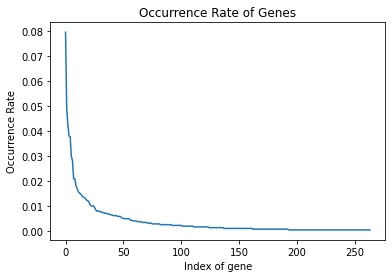

In [ ]:
# plot showing occurrence rate of genes (genes shown by index number) 
unique_gene = training_variants_raw_df['Gene'].value_counts()
occurrence_gene = unique_gene.values/training_variants_raw_df.shape[0]
plt.plot(occurrence_gene)
plt.xlabel('Index of gene')
plt.ylabel('Occurrence Rate')
plt.title('Occurrence Rate of Genes')
plt.show()

Outcomes: 
* **A small proportion of genes have a high occurrence rate.**
* **Most of the genes in the dataset have a low occurrence rate.**

In [ ]:
# Get top 20 most common genes

training_variants_raw_df['Gene'].value_counts().head(n=20)

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
PIK3CA     56
CDKN2A     52
FGFR2      50
FLT3       49
TSC2       47
MTOR       45
KRAS       44
MAP2K1     43
VHL        41
RET        40
Name: Gene, dtype: int64

Outcomes: 

**There are more common and less common genes. Of the 20 most common, 4/20 are unique genes commonly associated with breast/ovarian cancer suggesting a potential bias within the dataset.**

**Breast/Ovarian Cancer Genes:**
*   BRCA1<sup>1</sup>
*   BRCA2<sup>2</sup>
*   ERBB2 (HER2)<sup>3</sup>
*   PIK3CA<sup>4</sup>

**These may be due to the well characterization of breast, ovarian, and lung cancers and/or their relatively high occurance in society.**

---
*References:*

1) BRCA1 - My Cancer Genome. (n.d.). Retrieved June 15, 2021, from https://www.mycancergenome.org/content/gene/brca1/

2) BRCA2 - My Cancer Genome. (n.d.). Retrieved from https://www.mycancergenome.org/content/gene/brca2/

3) ERBB2 - My Cancer Genome. (n.d.). Retrieved June 15, 2021, from https://www.mycancergenome.org/content/gene/erbb2/

4) PIK3CA - My Cancer Genome. (n.d.). Retrieved June 15, 2021, from https://www.mycancergenome.org/content/gene/pik3ca/

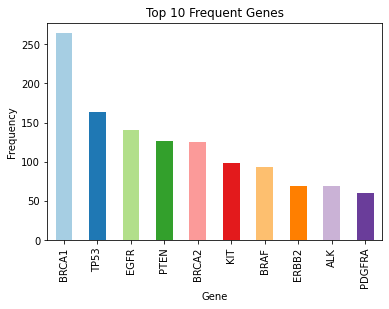

In [ ]:
# get top 10 most frequent genes and plot bar chart
top10_gene = unique_gene.head(10)
top10_gene.plot(kind='bar',x = 'Gene', y = 'ID',xlabel = 'Gene', ylabel = 'Frequency',
            title = 'Top 10 Frequent Genes',
            color=plt.cm.Paired(np.arange(len(top10_gene))))
plt.show()

### "Variation" Column Analysis

In [ ]:
# Univariate analysis for column "Variation"

# Get information of variations variable

training_variants_raw_df['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Outcomes:
- **Variation: the amino acid change for the mutation.**

- **Variation is a nominal categorical variable.**

- **There are 2996 unique amino acid change.**

- ** The most common variation is : Truncating Mutation which occur 93 times.**

In [ ]:
# check unique variation
unique_variation = training_variants_raw_df['Variation'].value_counts()
print(unique_variation)

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
E1021K                   1
L582F                    1
C47G                     1
R228K                    1
R882C                    1
Name: Variation, Length: 2996, dtype: int64


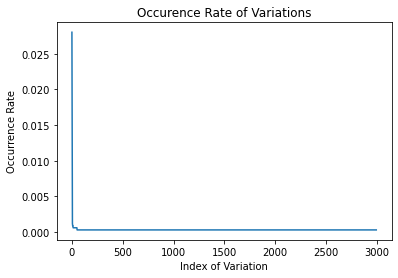

In [ ]:
# plot showing occurrence rate of vaiation (variation shown by index number)
occurrence_variation = unique_variation.values/training_variants_raw_df.shape[0]
plt.plot(occurrence_variation)
plt.xlabel('Index of Variation')
plt.ylabel('Occurrence Rate')
plt.title('Occurence Rate of Variations')
plt.show()

Outcomes: 
- ** A few variations have a high occurence rate, the rest have low occurence rates.**

In [ ]:
# getting top 10 most frequent variations
top10_var = unique_variation.head(10)
print('The top 10 frequent amino acid change: \n',top10_var)

The top 10 frequent amino acid change: 
 Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61H                     3
Q61R                     3
Q61L                     3
T58I                     3
Name: Variation, dtype: int64


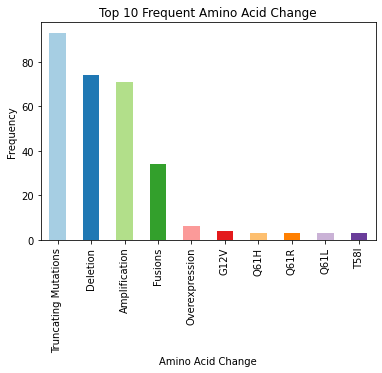

In [ ]:
# plot the top 10 frequent amino acid change
top10_var.plot(kind='bar',x = 'Gene', y = 'ID',xlabel = 'Amino Acid Change', ylabel = 'Frequency',
            title = 'Top 10 Frequent Amino Acid Change',
            color=plt.cm.Paired(np.arange(len(top10_var))))
plt.show()

Outcomes:

- **Most common mutation types:**
    *   Truncating mutations
    *   Deletion
    *   Amplification
    *   Fusion

- ** There are many single point mutations.**

---

## "Class" Column Analysis

In [ ]:
# univariate analysis on the column "Class"
# count the number of occurances of each class
class_counts = training_variants_raw_df['Class'].value_counts().sort_index()
print('The occurrences of each class are: \n',class_counts)

The occurrences of each class are: 
 1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
Name: Class, dtype: int64


Outcomes: 
- ** Class: 1 - 9 class type the genetic mutation has been classified on.**

- **'Class' is a nominal categorical variable.**

- **There are 9 unique class.**

In [ ]:
from matplotlib import cm

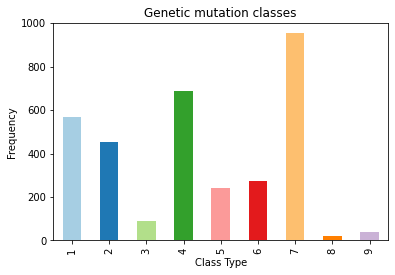

In [ ]:
# plot classes

class_counts.plot(kind='bar',x = 'Gene', y = 'ID',xlabel = 'Class Type', ylabel = 'Frequency',
                    title = 'Genetic mutation classes', 
                    color=plt.cm.Paired(np.arange(len(class_counts))))

plt.show()

Outcomes: 
* **Classes 3, 8, 9 seem to be in the minority.**
* **Classes 7, 4, 1 and maybe 2 seem to be in the majority.**

**Therefore, class doesn't have a notably positively skewed distribution.**

---

### Correlation between columns in variants and class using Cramer's Chi Squared correlation

**Class x Gene Correlation**

In [ ]:
training_variants_raw_df_categories = training_variants_raw_df.copy()

In [ ]:
crosstab_gene_class, res_gene_class = researchpy.crosstab(training_variants_raw_df_categories['Class'], training_variants_raw_df_categories['Gene'], test= "chi-square", margins=False)

**Gene and Class Two-Way Table**

In [ ]:
crosstab_gene_class

Gene                                             ...                  \
Gene  ABL1 ACVR1 AGO2 AKT1 AKT2 AKT3 ALK APC  AR ARAF  ... TSC1 TSC2 U2AF1   
Class                                                  ...                   
1        0     0    4    0    0    0   0   3   2    0  ...    3   23     0   
2       24     1    1    3    1    1   7   0   1    1  ...    0    0     0   
3        0     0    0    3    0    0  10   0   0    0  ...    6    0     0   
4        0     0    0    0    0    0   0   2   0    0  ...   10   23     0   
5        0     0    0    3    0    0   5   0   3    0  ...    1    0     0   
6        0     0    0    0    0    0   0   0   4    0  ...    0    0     0   
7        2     2    0   17    8    3  47   0  10    6  ...    0    1     0   
8        0     0    0    2    0    0   0   0   0    0  ...    0    0     0   
9        0     0    0    0    2    0   0   0   0    0  ...    0    0     3   

                                               
Gene  VEGFA VHL WHSC1 WHSC1L1 XPO1 XRCC2 YAP1  
Class                                          
1         0  15     0       0    0     2    0  
2         0   0     0       0    1     0    3  
3         0   0     0       0    0     0    0  
4         0  23     0       0    0     0    0  
5         0   2     0       0    0     0    0  
6         0   1     0       1    1     0    0  
7         1   0     1       0    0     0    1  
8         0   0     0       0    0     0    0  
9         0   0     0       0    0     0    0  

[9 rows x 264 columns]

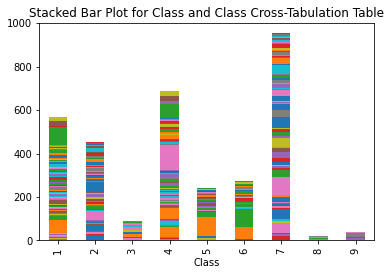

In [ ]:
# not showing legend for sake of presentation
crosstab_gene_class.plot(kind="bar", stacked=True, legend=None)
plt.xlabel("Class")
plt.title("Stacked Bar Plot for Class and Class Cross-Tabulation Table")
plt.show()

In [ ]:
# statistical analysis of crosstab
res_gene_class.loc[2]

Chi-square test    Cramer's V = 
results                   0.6148
Name: 2, dtype: object

**Cramer's V = 0.6148 indicates that there is a moderate correlation between the Class and Gene columns**

---

**Class x Variation Correlation**

In [ ]:
crosstab_variation_class, res_variation_class = researchpy.crosstab(training_variants_raw_df_categories['Class'], training_variants_raw_df_categories['Variation'], test= "chi-square", margins=False)

**Variation and Class Two-Way Table**

In [ ]:
crosstab_variation_class

Variation                                                     \
Variation 1_2009trunc 2010_2471trunc 256_286trunc 3' Deletion 385_418del   
Class                                                                      
1                   1              0            0           0          0   
2                   0              1            0           0          0   
3                   0              0            0           0          0   
4                   0              0            0           1          1   
5                   0              0            0           0          0   
6                   0              0            0           0          0   
7                   0              0            1           0          0   
8                   0              0            0           0          0   
9                   0              0            0           0          0   

                                                                      ...  \
Variation 422_605trunc 533_534del 534_536del 550_592del 560_561insER  ...   
Class                                                                 ...   
1                    0          0          0          0            0  ...   
2                    0          1          1          0            0  ...   
3                    0          0          0          0            0  ...   
4                    0          0          0          0            0  ...   
5                    0          0          0          0            0  ...   
6                    0          0          0          0            0  ...   
7                    1          0          0          1            1  ...   
8                    0          0          0          0            0  ...   
9                    0          0          0          0            0  ...   

                                                                             \
Variation Y87N Y901C Y931C Y98H Y98N YAP1-FAM118B Fusion YAP1-MAMLD1 Fusion   
Class                                                                         
1            0     0     0    1    1                   0                  0   
2            0     0     0    0    0                   1                  1   
3            0     0     0    0    0                   0                  0   
4            1     1     0    0    0                   0                  0   
5            0     0     0    0    0                   0                  0   
6            0     0     1    0    0                   0                  0   
7            0     0     0    0    0                   0                  0   
8            0     0     0    0    0                   0                  0   
9            0     0     0    0    0                   0                  0   

                                                          
Variation ZC3H7B-BCOR Fusion ZNF198-FGFR1 Fusion p61BRAF  
Class                                                     
1                          0                   0       0  
2                          0                   0       0  
3                          0                   0       0  
4                          0                   0       0  
5                          0                   0       0  
6                          0                   0       0  
7                          0                   1       1  
8                          1                   0       0  
9                          0                   0       0  

[9 rows x 2996 columns]

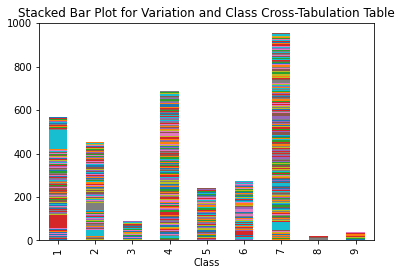

In [ ]:
# not showing legend for sake of presentation
crosstab_variation_class.plot(kind="bar", stacked=True, legend=None)
plt.title("Stacked Bar Plot for Variation and Class Cross-Tabulation Table")
plt.show()

In [ ]:
# statistical analysis of crosstab
res_variation_class.loc[2]

Chi-square test    Cramer's V = 
results                   0.9813
Name: 2, dtype: object

**Cramer's V = 0.9813 indicates a strong correlation between Variations and Class**

---

**Gene x Variation Correlation**

In [ ]:
crosstab_variation_gene, res_variation_gene = researchpy.crosstab(training_variants_raw_df_categories['Gene'], training_variants_raw_df_categories['Variation'], test= "chi-square", margins=False)

**Variation and Gene Two-Way Table**

In [ ]:
crosstab_variation_gene

Variation                                                     \
Variation 1_2009trunc 2010_2471trunc 256_286trunc 3' Deletion 385_418del   
Gene                                                                       
ABL1                0              0            0           0          0   
ACVR1               0              0            0           0          0   
AGO2                0              0            0           0          0   
AKT1                0              0            0           0          0   
AKT2                0              0            0           0          0   
...               ...            ...          ...         ...        ...   
WHSC1               0              0            0           0          0   
WHSC1L1             0              0            0           0          0   
XPO1                0              0            0           0          0   
XRCC2               0              0            0           0          0   
YAP1                0              0            0           0          0   

                                                                      ...  \
Variation 422_605trunc 533_534del 534_536del 550_592del 560_561insER  ...   
Gene                                                                  ...   
ABL1                 0          0          0          0            0  ...   
ACVR1                0          0          0          0            0  ...   
AGO2                 0          0          0          0            0  ...   
AKT1                 0          0          0          0            0  ...   
AKT2                 0          0          0          0            0  ...   
...                ...        ...        ...        ...          ...  ...   
WHSC1                0          0          0          0            0  ...   
WHSC1L1              0          0          0          0            0  ...   
XPO1                 0          0          0          0            0  ...   
XRCC2                0          0          0          0            0  ...   
YAP1                 0          0          0          0            0  ...   

                                                                             \
Variation Y87N Y901C Y931C Y98H Y98N YAP1-FAM118B Fusion YAP1-MAMLD1 Fusion   
Gene                                                                          
ABL1         0     0     0    0    0                   0                  0   
ACVR1        0     0     0    0    0                   0                  0   
AGO2         0     0     0    0    0                   0                  0   
AKT1         0     0     0    0    0                   0                  0   
AKT2         0     0     0    0    0                   0                  0   
...        ...   ...   ...  ...  ...                 ...                ...   
WHSC1        0     0     0    0    0                   0                  0   
WHSC1L1      0     0     0    0    0                   0                  0   
XPO1         0     0     0    0    0                   0                  0   
XRCC2        0     0     0    0    0                   0                  0   
YAP1         0     0     0    0    0                   1                  1   

                                                          
Variation ZC3H7B-BCOR Fusion ZNF198-FGFR1 Fusion p61BRAF  
Gene                                                      
ABL1                       0                   0       0  
ACVR1                      0                   0       0  
AGO2                       0                   0       0  
AKT1                       0                   0       0  
AKT2                       0                   0       0  
...                      ...                 ...     ...  
WHSC1                      0                   0       0  
WHSC1L1                    0                   0       0  
XPO1                       0                   0       0  
XRCC2                      0                   0     

In [ ]:
res_variation_gene.loc[2]

Chi-square test    Cramer's V = 
results                   0.8004
Name: 2, dtype: object

** Cramer's V = 0.8004 indicates there is a strong correlation between Variation and Gene**

---

**Summary of Correlations**

In [ ]:
gene_class_v = res_gene_class.loc[2][1]
variation_class_v = res_variation_class.loc[2][1]
variation_gene_v = res_variation_gene.loc[2][1]
correlation_df = pd.DataFrame(index=["Gene", "Variation", "Class"], columns=["Gene", "Variation", "Class"])

correlation_df.Gene[0] = 1
correlation_df.Gene[1] = variation_gene_v
correlation_df.Gene[2] = gene_class_v

correlation_df.Variation[0] = variation_gene_v
correlation_df.Variation[1] = 1
correlation_df.Variation[2] = variation_class_v

correlation_df.Class[0] = gene_class_v
correlation_df.Class[1] = variation_class_v
correlation_df.Class[2] = 1

correlation_df

,Gene,Variation,Class
Gene,1,0.8004,0.6148
Variation,0.8004,1,0.9813
Class,0.6148,0.9813,1


## "Text" Exploratory Data Analysis

**"Text" Data Analysis**

In [ ]:
# Get data shape

print("Sample size:", training_text_raw_df.shape[0])  # records
print("Number of Features:", training_text_raw_df.shape[1])  # number of columns
print("Features:", training_text_raw_df.columns.values)  # column names

Sample size: 3321
Number of Features: 2
Features: ['ID' 'TEXT']


In [ ]:
# Get first 5 values

training_text_raw_df.head(n=5)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
# Get last 5 values

training_text_raw_df.tail(n=5)

,ID,TEXT
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,The most frequent mutations associated with le...


In [ ]:
training_text_raw_df.describe(include='all')

,ID,TEXT
count,3321.000000,3316
unique,NaN,1920
top,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,53
mean,1660.000000,NaN
std,958.834449,NaN
min,0.000000,NaN
25%,830.000000,NaN
50%,1660.000000,NaN
75%,2490.000000,NaN


In [ ]:
# Number of nulls per column
training_text_raw_df.info()
training_text_raw_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


ID      0
TEXT    5
dtype: int64

In [ ]:
# Get number of unique text descriptions

num_unique_text = training_text_raw_df['TEXT'].nunique(dropna= True)
print("The number of unique text descriptions is {}.".format(num_unique_text))
print("The number of duplicate text descriptions is {}.".format(3316-num_unique_text))

The number of unique text descriptions is 1920.
The number of duplicate text descriptions is 1396.


Outcomes:
* ** There are no missing values in the ID column & every ID is unique.**
* **There are 5 rows with missing text descriptions.**
* **The actual number of text descriptions is 3316**
* **Some of the texts are duplicates. There are 1920 unique texts.**
* **The most frequent text occurs 53 times - doesn't seem dramatically over-represented.**



**Looking at raw word frequencies**

In [ ]:
# Removing the rows with missing values, so the next code chunk doesn't throw an error.

training_text_raw_no_na = training_text_raw_df.dropna(axis=0)
training_text_raw_no_na['TEXT'].describe(include=all)

count                                                  3316
unique                                                 1920
top       The PTEN (phosphatase and tensin homolog) phos...
freq                                                     53
Name: TEXT, dtype: object

In [ ]:
# Counting the occurences of each word in the dataframe.

word_count_raw_df = (' '.join(training_text_raw_no_na['TEXT']).split()).value_counts().reset_index()
word_count_raw_df.columns = ["Word", "Occurrences"]
word_count_raw_df.head()

NameError: name 'pd' is not defined

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
# Describe the word counts of the (mostly) raw data
word_count_raw_df.describe(include='all')

,Word,Occurrences
count,484091,4.840910e+05
unique,484091,NaN
top,TD1(Arg248Cys),NaN
freq,1,NaN
mean,NaN,6.552330e+01
std,NaN,3.616249e+03
min,NaN,1.000000e+00
25%,NaN,1.000000e+00
50%,NaN,2.000000e+00
75%,NaN,7.000000e+00


In [ ]:
top50_word_count_raw = word_count_raw_df.sort_values(
    by="Occurrences", ascending=False).head(50)

alt.Chart(...)

In [ ]:
bottom50_word_count_raw = word_count_raw_df.sort_values(
    by="Occurrences", ascending=True).head(50)

alt.Chart(...)

Outcomes: 

**Based on the IQR, we'll keep words that occur between 1 and 7 times. Words that occur once are in the 25th quartile and words that occur 7 times are in our 75th quartile.**

**If by only keeping words that occur between 1 and 7 times, we remove too many words, we may use the bar chart to decide which words to keep. Based on the bar charts, we might want to keep words that occur more than 100,000 times. When we look at the barchart of top 50 frequent words, most words seem to have occurences below 100,000.**

**Note that this analysis of word counts is based on raw data, so words like, 'the' and 'The' are treated like separate words.**

## Initial Pre-processing

### Cleaning variants data

** group variation into broader categories **

In [ ]:
# Remove a row if the variant consists of only one character. (we're considering it dirty data.)
def remove_dirty_var(df):
    """
    This function removes a row of a dataframe if a record
    in the 'Variation' column contains only one character.
    We are considering one character variants, 'dirty data'.
    Inplace = True.
    :param df: A pandas dataframe
    :return: Returns a modified dataframe.
    """
    index_dirty_var = df[df['Variation'].map(len) <= 1].index.to_list()
    df = df.drop(index=index_dirty_var)
    return df

training_var_clean = training_variants_raw_df.copy()
test_var_clean_stage2 = test_variants_raw_df_stage2.copy()

training_var_clean = remove_dirty_var(training_var_clean)
test_var_clean_stage2 = remove_dirty_var(test_var_clean_stage2)

**Amino acid variation nomenclature**

http://atlasgeneticsoncology.org/Educ/NomMutID30067ES.html

http://www.hgvs.org/mutnomen/recs-prot.html

`ins` = insertion, `number1_number2` = between number 1 and number 2

`del` or `*` = deletion

`dup` = duplication

`inv` = inversion

`X` = stop codon

substituion example: `P252R` 

`fsX`, `fs` = frameshift

`-` = range

`delins` ~ indel (insertion or deletions of a base)

---

sometimes in the data, says `Fusion` othertimes, says `protein1-protein2 Fusion`


In [ ]:
def categorize_variations(df, text, category):
    """
    This function categorizes similar variations.
    Inplace = True.
    :param df: A pandas dataframe.
    :param text: The text used to match a variation
        in the dataframe (string).
    :param category: The category that the text
        will be replaced with (string).
    :return: Returns a modified pandas dataframe.
    """
    df['Variation'].apply(lambda x:df.replace(x,category,inplace= True) if (text in x.lower()) else x)
    return df

In [ ]:
def execute_categorize_var(df):
    """
    This function will call categorize_variations() to 
    groups variations into broader categories. 
    Amino acid nomenclature was used to determine 
    how a variation should be classified.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified dataframe.
    """
    txt_cat_lst = [['dna', 'DNA BD'], ['fusion', 'Fusion'],
               ['truncating', 'Truncating'], ['dup', 'Duplication'],
               ['inv', 'Inversion'], ['delins', 'Indel'],
               ['insertion', 'Insertion'], ['ins', 'Insertion'],
               ['del', 'Deletion'], ['deletion/insertion', 'Indel'],
               ['fs','Frameshift'], ['splice','Splice'],['*','Deletion'],['trunc','Truncating']]
    for txt_cat in txt_cat_lst:
        text, category = txt_cat
        df_categorized = categorize_variations(df, text, category)
    return df_categorized

In [ ]:
# Execute categorization functions.
training_var_clean = execute_categorize_var(training_var_clean)
test_var_clean_stage2 = execute_categorize_var(test_var_clean_stage2)

** Convert AA replacements with type of AA conversion**

In [ ]:
def ss_mutation_type(x, aa_type_dict):
	"""
	This function determines the broader category of a variation.
	The broader categories are determined by the aa_type_dict.
	:param x: The variation value (string).
	:param aa_type_dict: A dictionary of categories and their corresponding amino acids.
	:return: Returns the specific variation's category (string).
	"""
	type_before = ''

	type_after = ''
	
	for type in aa_type_dict:
		if x[0] in aa_type_dict[type]:
			type_before = type
		if x[len(x) - 1] in aa_type_dict[type]:
			type_after = type
	return type_before + ' to ' + type_after

In [ ]:
#catergorize amino acids based on their hydrophobicity
hydrophobicity_dict = {'hydrophobic': ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P'],
					   'hydrophilic': ['S', 'T', 'N', 'Q', 'D', 'E', 'K', 'R', 'H', 'C', 'Y']}

In [ ]:
# Get substitution categories where categories are based on hydrophobicity.
# Training
training_var_clean['Variation'].\
	apply(lambda x: training_var_clean.
		  replace(x, ss_mutation_type(x, hydrophobicity_dict),
				  inplace=True) if (x[0].isupper() and x[len(x) - 1].
									isupper()) else x)

# Test Stage2
test_var_clean_stage2['Variation'].\
	apply(lambda x: test_var_clean_stage2.
		  replace(x, ss_mutation_type(x, hydrophobicity_dict),
				  inplace=True) if (x[0].isupper() and x[len(x) - 1].
									isupper()) else x)
test_var_clean_stage2['Variation'].value_counts().head(n=2)

hydrophilic to hydrophilic    310
hydrophilic to hydrophobic    203
Name: Variation, dtype: int64

In [ ]:
print('The list of new unique categories of variation:')
print(training_var_clean.Variation.unique())

The list of new unique categories of variation:
['Truncating' 'Deletion' 'hydrophilic to hydrophilic'
 'hydrophobic to hydrophobic' 'hydrophilic to hydrophobic'
 'Promoter Mutations' 'hydrophobic to hydrophilic' 'Amplification'
 'Promoter Hypermethylation' 'Frameshift' 'Overexpression' 'Duplication'
 'Insertion' 'Fusion' 'Splice' 'Epigenetic Silencing' 'R1627' 'C1385'
 'Copy Number Loss' 'Hypermethylation' 'ARv567es' 'AR-V7' 'MYC-nick'
 'p61BRAF' 'Exon 11 mutations' 'Exon 9 mutations' 'Exon 1 mutations'
 'Exon 2 mutations' 'DNMT3B7' 'Wildtype']


### Read/Write Variants Data.

In [ ]:
# Save the clean variants datasets.

training_var_clean.to_csv("training_variants_clean.csv", index=False)
test_var_clean_stage2.to_csv("test_variants_clean_stage2.csv", index=False)

### Preprocessing the text data

** Remove missing values**

In [ ]:
# Remove rows with missing text.
def remove_missing(df): 
    """
    This function removes rows of a dataframe whose
    records have missing values.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified dataframe.
        Prints messages to the user.
    """
    print('sample size before dropping:',df.shape[0])
    df_no_na = df.dropna()
    print('sample size after dropping:',df_no_na.shape[0])
    return df_no_na

print("Training")
training_text_clean = remove_missing(training_text_raw_df)
print("\nTest Stage 2")
test_text_clean_stage2 = remove_missing(test_text_raw_df_stage2)

Training
sample size before dropping: 3321
sample size after dropping: 3316

Test Stage 2
sample size before dropping: 986
sample size after dropping: 986


** Remove stop words and non-alphanumeric words **

In [ ]:
# Function for initial text formatting.

stop_words = set(stopwords.words('english'))

def preprocessing(text):  # edit each row
  """
  Used to modify the text of each row in our dataframe.
  This function does a variety of text pre-processing.
  1) Replace non-alpha numeric characters with a space.
  2) Remove all periods, except those at the end of sentences.
  3) Replace multiple spaces with a single space.
  4) Make all text lowercase.
  5) Remove english stopwords from nltk.
  Inplace = True.
  :param text: A string of text.
  :return: Returns a processed string of text.
  """
  if type(text) is not int:
    string = ""
    # replacing all non alphanumeric characters with a space except for periods
    text = re.sub('[^a-zA-Z0-9.\n]', ' ', text)
    # only gets rid of periods that occur in between words, as opposed to those that occur at the end of a sentence
    # need to keep the ones at the end of the sentence to split them when looking for specific sentences talking about specific genes
    text = re.sub('(\.)(?=\w+)', ' ', text)
    # replacing consecutive spaces with just 1 space in case there are special chars one after another
    text = re.sub('\s+',' ', text)
    # make everything lower case
    text = text.lower()

  for word in text.split():   # split into list, list contain each word
    if not word in stop_words:   # if word is not in stopwords, keep the word
      string += word + " "
  return string


In [ ]:
# Function that calls preprocessing function.
def execute_preprocess(df): 
  """
  This function calls preprocessing() on 
  every row of text in the dataframe.
  Inplace = True.
  :param df: The pandas dataframe containing text data.
  :return: Returns a processed pandas dataframe.
  """
  for index, row in df.iterrows():
    if type(row['TEXT']) is str:
      df['TEXT'][index] = preprocessing(row['TEXT'])   # run the function for each row
    else:
      # text that are not strings are converted to empty strings
      df['TEXT'][index] = ''
      print("no text description found for id:", index)
  return df


In [ ]:
# Call execute_preprocess for training dataset
training_text_clean = execute_preprocess(training_text_clean)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Call execute_preprocess for stage 2 dataset
test_text_clean_stage2 = execute_preprocess(test_text_clean_stage2)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


** Only Keep Sentences including gene corresponding **

In [ ]:
# Function for merged text and its relevant gene 
def merge_gene(var_df, text_df): 
    """
    This function merges the variation and text
    pandas dataframes based on ID. it only use 'Gene' 
    and 'Text' as variables of new dataframe.
    :param var_df: The variation pandas dataframe.
    :param text_df: The text pandas dataframe.
    :return: Returns a pandas dataframe.
    """
    gene_col = var_df[['ID', 'Gene']]
    text_gene_df = pd.merge(text_df, gene_col, on="ID")
    return text_gene_df

training_text_clean = merge_gene(training_variants_raw_df, training_text_clean)
test_text_clean_stage2 = merge_gene(test_variants_raw_df_stage2, test_text_clean_stage2)

In [ ]:
def get_sentences(df): 
    """
    This function splits every sentence of text
    to create a list of sentences in each row of the
    dataframe.
    Inplace = True.
    :param df: A pandas dataframe with a string in the
        'TEXT' column.
    :return: Returns a pandas dataframe with lists of strings
        in the 'TEXT' column.
    """
    df["TEXT"] = df["TEXT"].apply(lambda x: x.split("."))
    return df

training_text_clean = get_sentences(training_text_clean)
test_text_clean_stage2 = get_sentences(test_text_clean_stage2)

training_text_clean.head(n=2)

,ID,TEXT,Gene
0,0,[cyclin dependent kinases cdks regulate variet...,FAM58A
1,1,[abstract background non small cell lung cance...,CBL


In [ ]:
def get_rel_sentences(df): 
    """
    This function iterates through every sentence in each row. 
    Only sentences that include the gene corresponding to that row
    are kept in the dataframe.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a pandas dataframe whose 'TEXT' column contains 
        a shorter list of strings in each row.
    """
    for index, row in df.iterrows():
        geneName = row["Gene"]
        geneName = geneName.lower()
        for index, val in enumerate(row["TEXT"]):
            if geneName not in val:
                del row["TEXT"][index]
    return df

training_text_clean = get_rel_sentences(training_text_clean)
test_text_clean_stage2 = get_rel_sentences(test_text_clean_stage2)

In [ ]:
def lst_to_str(df): 
    """
    For each row in the dataset, this function 
    joins a list of strings into one string. 
    Only works in the 'TEXT' column.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified pandas dataframe.
    """
    df["TEXT"] = df["TEXT"].apply(lambda x: ' '.join(x))
    return df

training_text_clean = lst_to_str(training_text_clean)
test_text_clean_stage2 = lst_to_str(test_text_clean_stage2)

In [ ]:
def remove_gene_col(df): 
    """
    This function removes a column called, 
    'Gene' from a pandas dataframe.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a pandas dataframe.
    """
    del df["Gene"]
    return df

training_text_clean = remove_gene_col(training_text_clean)
test_text_clean_stage2 = remove_gene_col(test_text_clean_stage2)

**Removing digits**

In [ ]:
def remove_digits_text(df): 
    """
    This function removes words that are digits 
    from the text string of each row in dataframe.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified pandas dataframe.
    """
    df['TEXT'] = df['TEXT'].apply(lambda x: ' '.join(x for x in x.split() if x.isdigit() is False))
    return df

training_text_clean = remove_digits_text(training_text_clean)
test_text_clean_stage2 = remove_digits_text(test_text_clean_stage2)

training_text_clean.head(n=2)

,ID,TEXT
0,0,cdk10 stands one last orphan cdks activating c...
1,1,c cbl e3 ubiquitin ligase adaptor molecule imp...


**Removing 1 letter words**

In [ ]:
def remove_1_chr_words(df): 
    """
    This function removes 1 character words
    from the text string for each row the dataframe.
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified pandas dataframe.
    """ 
    df['TEXT'] = df['TEXT'].apply(lambda x: ' '.join(x for x in x.split() if len(x) > 1))
    return df

training_text_clean = remove_digits_text(training_text_clean)
test_text_clean_stage2 = remove_digits_text(test_text_clean_stage2)

training_text_clean.head(n=2)

,ID,TEXT
0,0,cdk10 stands one last orphan cdks activating c...
1,1,c cbl e3 ubiquitin ligase adaptor molecule imp...


**Remove words that are combinations of words and digits.**

In [ ]:
def remove_w_d_combo(df): 
    """
    This function removes words that contain both 
    alphabetic and numeric characters. 
    Inplace = True.
    :param df: A pandas dataframe.
    :return: Returns a modified pandas dataframe.
    """
    df["TEXT"] = df["TEXT"].map(lambda x: " ".join([word for word in x.split(" ") if word.isalpha()]))
    return df

training_text_clean = remove_digits_text(training_text_clean)
test_text_clean_stage2 = remove_digits_text(test_text_clean_stage2)

**Keep Verbs and adjectives (Tokenization) **

In [ ]:
def get_word_counts_df(df):
    """
    This function counts the number of occurrences of each 
    word in the dataset. The words and corresponding 
    number of occurrences are stored in a new pandas 
    dataframe variable.
    :param df: A pandas dataframe.
    :return: Returns a pandas dataframe of words and their
        number of occurrences.
    """
    count_vect = CountVectorizer()
    count_vect.fit_transform(df['TEXT'])
    word_counts = count_vect.vocabulary_
    word_counts_df = pd.Series(word_counts).to_frame().reset_index(level=0)
    word_counts_df.columns = ["Word", "Occurences"]
    return word_counts_df

In [ ]:
def get_token_counts(df):
    """
    This function gets the part of speech tag for each 
    word in the dataframe. Adds the tag information to the 
    dataframe in a new column.
    Calls get_word_counts_df() to get the words.
    :param df: A pandas dataframe.
    :return: Returns a dataframe of word, number of occurences, 
        and the word's part of speech tag.
    """
    count_tokens = get_word_counts_df(df)
    count_tokens["WordType"] = nltk.pos_tag_sents(count_tokens["Word"].apply(nltk.word_tokenize).tolist())
    count_tokens["WordType"] = count_tokens["WordType"].apply(lambda x: x[0][1])
    return count_tokens

In [ ]:
training_count_tokens = get_token_counts(training_text_clean)
training_count_tokens.head(n=2)

In [ ]:
test_count_tokens_stage2 = get_token_counts(test_text_clean_stage2)

In [ ]:
def get_jj_vb(df):
    """
    This function extracts words whose parts of speech are 
    either adjective (starts with jj) or verb (starts with vb).
    Inplace = False
    :param df: A pandas dataframe.
    :return: Returns a new pandas dataframe.
    """
    jj_vv_words = df.copy()
    jj_vv_words = jj_vv_words[jj_vv_words["WordType"].apply(lambda x: x.startswith('JJ') or x.startswith('VB'))]
    return jj_vv_words

training_text_jjvb = get_jj_vb(training_count_tokens)
test_text_jjvb_stage2 = get_jj_vb(test_count_tokens_stage2)

In [ ]:
training_jjvb_set = set(training_text_jjvb.Word)
test_jjvb_set_stage2 = set(test_text_jjvb_stage2.Word)

print("Training adjective and verb words: ", training_jjvb_set)

Training adjective and verb words:  {'notwithstanding', 'equal', 'swelled', 'haering', 'traversed', 'exporting', 'modeling', 'segregating', 'physicochemical', 'hybridising', 'minisequencing', 'fluttering', 'mutantstable', 'refusing', 'spicing', 'gyral', 'signified', 'dichotomized', 'nulliparous', 'proferring', 'entrenched', 'stacked', 'infected', 'western', 'ofobserved', 'reintroducing', 'clarified', 'pathogenetical', 'cancerpredisposing', 'small', 'shortening', 'reduced', 'menstrual', 'isotypematched', 'interchanging', 'centrifuged', 'gave', 'nonneuronal', 'perceptible', 'unconserved', 'smoked', 'hbhcontaining', 'prediluted', 'ingeneral', 'humidified', 'noble', 'deparaffinised', 'electrochemical', 'subpolymorphic', 'unconventional', 'consed', 'nazarian', 'contemporaneous', 'markedstimulated', 'pharmascan', 'microbiological', 'feasible', 'designated', 'repeated', 'nonaffected', 'ncubated', 'pitting', 'housed', 'seminiferous', 'founding', 'graphed', 'wincluding', 'consisting', 'surround

In [ ]:
def remove_words(df, word_set):
    """
    For each row in the 'TEXT' column of a dataframe, 
    words are removed from a text string if they are 
    in a set of words.
    Inplace = False.
    :param df: A pandas dataframe.
    :param word_set: A set of words to be removed. 
        (set of strings).
    :return: Returns a new pandas dataframe.
    """
    removed_df = df.copy()
    removed_df['TEXT'] = removed_df['TEXT'].apply(lambda x: ' '.join(x for x in x.split() if x in word_set))
    return removed_df

training_text_clean = remove_words(training_text_clean, training_jjvb_set)
test_text_clean_stage2 = remove_words(test_text_clean_stage2, test_jjvb_set_stage2)

training_text_clean.head(n=2)

,ID,TEXT
0,0,last activating identified revealed elusive si...
1,1,important normal determined genetic using fixe...


** stem words **

In [ ]:
def stem_words(df):
    """
    For each row in the 'TEXT' column of a dataframe, 
    stem words in a text string.
    Inplace = False.
    :param df: A pandas dataframe.
    :return: Returns a new pandas dataframe.
    """
    df_stemmed = df.copy()
    porter = PorterStemmer()
    df_stemmed["TEXT"] = df_stemmed["TEXT"].\
        map(lambda x: " ".join([porter.stem(word)
                                for word in x.split(" ")]))
    return df_stemmed

In [ ]:
training_text_clean = stem_words(training_text_clean)
training_text_clean.head(n=2)

,ID,TEXT
0,0,last activ identifi reveal elus silenc silenc ...
1,1,import normal determin genet use fix embed ext...


In [ ]:
test_text_clean_stage2 = stem_words(test_text_clean_stage2)

### Read/Write Text Data

In [ ]:
# Write the text cleaning dataframes to a csv file in our project's folder.
# Won't have to run text pre-processing code again

training_text_clean.to_csv("training_text_clean.csv", index=False)
test_text_clean_stage2.to_csv("test_text_clean_stage2.csv", index=False)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3429806-221b-4e18-a695-754269d0015a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>